# Project 11: Linear Algebra


# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

## Data Preprocessing & Exploration

### Initialization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

import math

### Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2336,0,21.0,33200.0,1,0
2982,0,29.0,46800.0,2,0
1122,1,24.0,40500.0,1,0
982,1,51.0,29000.0,2,2
2453,1,21.0,26700.0,4,0
2649,1,29.0,38800.0,5,0
343,0,25.0,54900.0,1,0
4073,0,19.0,35400.0,2,0
3446,0,39.0,58500.0,0,0
3557,0,22.0,50100.0,4,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype(int)

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics.

df.describe()

# Does everything look okay? So far yes but let's check for missing or duplicated values

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [9]:
print('Check for Missing Values')
print(df.isna().sum())
print()
print('Check for Duplicate Rows')
print('There are', df.duplicated().sum(), 'duplicate rows')
print()
# There is a chance that out of 5000 customers, 153 share some demographic and insurance information with others,
# but not likely - to be safe, let's remove these values
df = df.drop_duplicates()
df.info()

Check for Missing Values
gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

Check for Duplicate Rows
There are 153 duplicate rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   int64  
 2   income              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 227.2 KB


Everything appears to be fine in the dataset after removing duplicates.

### EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

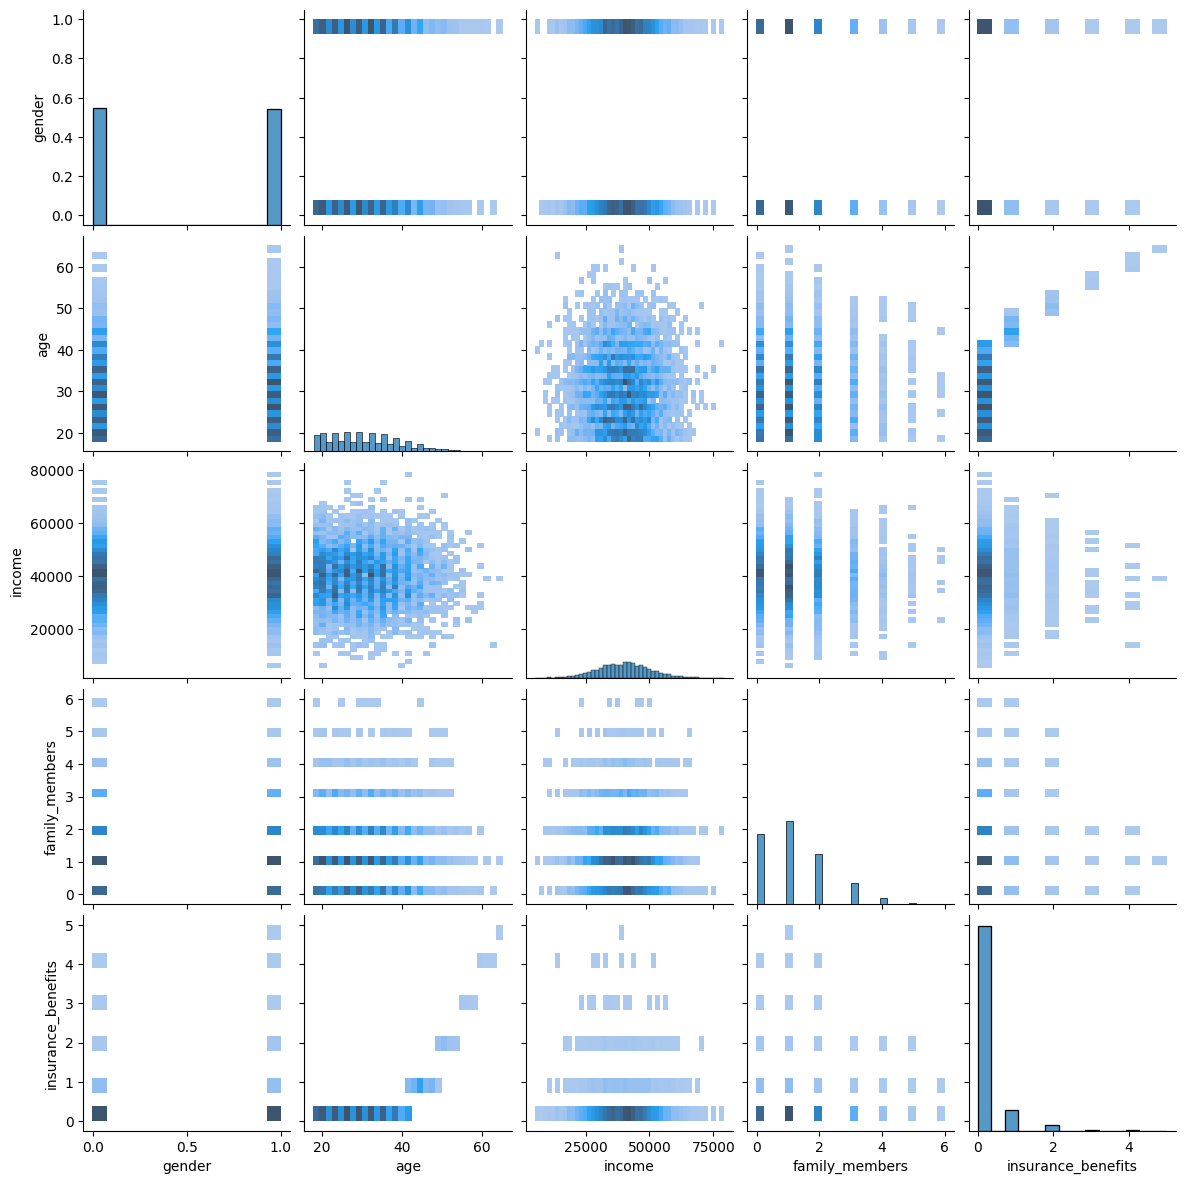

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

### Data Preprocessing & Exploration Conclusion

The data appears correctly formatted and free from any issues that would inhibit further analysis, such as missing or duplicate values. We converted the age variable from float to int and checked descriptive statistics. The gender split is almost equal and the other values look reasonably distributed.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [11]:
# Specify df columns that are features for the model
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
# Create kNN model to predict number of insurance benefits based on features
# Parameters are defined below
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [13]:
# Fit MaxAbsScaler to scale features
feature_names = ['gender', 'age', 'income', 'family_members']
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

# Create a copy of df with scaled/transformed features
df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
# Show sample of scaled data
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1117,0.0,0.476923,0.491139,0.000000,0
3892,1.0,0.692308,0.451899,0.000000,1
954,1.0,0.707692,0.508861,0.500000,1
3301,1.0,0.615385,0.545570,0.166667,0
3451,1.0,0.676923,0.443038,0.000000,1


## Test kNN Algorithm on All Combinations of Distance and & Scaling

Now, let's get similar records for a given one for every combination

In [15]:
# Selecting a random "n" user to compare kNN to
# In the steps that follow, I will find the closest 5 neighbors in terms of distance to user in row 123
df.iloc[123][feature_names]

gender                1.0
age                  27.0
income            38000.0
family_members        5.0
Name: 123, dtype: float64

### Euclidean + Scaled

In [16]:
euclidean_scaled = get_knn(df_scaled, n=123, k=5, metric='euclidean')
euclidean_scaled

,gender,age,income,family_members,insurance_benefits,distance
123,1.0,0.415385,0.481013,0.833333,0.0,0.000000
1003,NaN,NaN,NaN,NaN,NaN,0.042149
1009,NaN,NaN,NaN,NaN,NaN,0.062584
1011,1.0,0.400000,0.441772,0.833333,0.0,NaN
1017,1.0,0.353846,0.492405,0.833333,0.0,NaN
2182,NaN,NaN,NaN,NaN,NaN,0.080774
2216,1.0,0.384615,0.555696,0.833333,0.0,NaN
2594,NaN,NaN,NaN,NaN,NaN,0.032393
2649,1.0,0.446154,0.491139,0.833333,0.0,NaN


### Euclidean + Unscaled

In [17]:
euclidean_unscaled = get_knn(df, n=123, k=5, metric='euclidean')
euclidean_unscaled

,gender,age,income,family_members,insurance_benefits,distance
123,1.0,27.0,38000.0,5.0,0.0,0.000000
142,0.0,22.0,38000.0,2.0,0.0,5.916080
1876,NaN,NaN,NaN,NaN,NaN,3.162278
1905,1.0,26.0,38000.0,2.0,0.0,NaN
1973,NaN,NaN,NaN,NaN,NaN,6.403124
2003,1.0,22.0,38000.0,1.0,0.0,NaN
3437,NaN,NaN,NaN,NaN,NaN,5.099020
3531,0.0,27.0,38000.0,0.0,0.0,NaN


### Manhattan + Scaled

In [18]:
manhattan_scaled = get_knn(df_scaled, n=123, k=5, metric='manhattan')
manhattan_scaled

,gender,age,income,family_members,insurance_benefits,distance
123,1.0,0.415385,0.481013,0.833333,0.0,0.000000
1003,NaN,NaN,NaN,NaN,NaN,0.054625
1009,NaN,NaN,NaN,NaN,NaN,0.072931
1011,1.0,0.400000,0.441772,0.833333,0.0,NaN
1017,1.0,0.353846,0.492405,0.833333,0.0,NaN
2182,NaN,NaN,NaN,NaN,NaN,0.105453
2216,1.0,0.384615,0.555696,0.833333,0.0,NaN
2594,NaN,NaN,NaN,NaN,NaN,0.040896
2649,1.0,0.446154,0.491139,0.833333,0.0,NaN


### Manhattan + Unscaled

In [19]:
manhattan_unscaled = get_knn(df, n=123, k=5, metric='manhattan')
manhattan_unscaled

,gender,age,income,family_members,insurance_benefits,distance
123,1.0,27.0,38000.0,5.0,0.0,0.0
142,0.0,22.0,38000.0,2.0,0.0,9.0
1876,NaN,NaN,NaN,NaN,NaN,4.0
1905,1.0,26.0,38000.0,2.0,0.0,NaN
1973,NaN,NaN,NaN,NaN,NaN,9.0
2003,1.0,22.0,38000.0,1.0,0.0,NaN
3437,NaN,NaN,NaN,NaN,NaN,6.0
3531,0.0,27.0,38000.0,0.0,0.0,NaN


### Answers to the questions

#### **Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Scaling data does have an effect on the kNN algorithm, demonstrated by the distances being returned in each combination above. Without scaling, the algorithm is placing a greater weight on the income feature than the others because it contains larger data values than gender, family members, and age. Scaling normalizes all features to values between 0 and 1, therefore smaller distances are calculated with scaled features. For example, in the above results, distances for scaled data were all between 0.03 and 0.11 while distances for unscaled data ranged from 4 to 9.

#### **How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Both Euclidean and Manhattan distance metrics identify the same 4 nearest neighbors to the original user (n=123). This is true for both scaled and unscaled data (Euclidean Scaled = Manhattan Scaled, Euclidean Non-Scaled = Manhattan Non-Scaled. The non-scaled data appears to be placing an outsized weight on income, due to the larger data values discussed in the previous answer, whereas the scaled data is providing nearest neighbors across all of the features more evenly.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
# Calculate the target (insurance_benefits > 0)
# If insurance_benefits > 0, > 1, else 0
df['insurance_benefits_received'] = np.where(df['insurance_benefits'] > 0, 1, 0)

In [21]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

Findings: There are far more users who have never received any insurance benefits over the last 5 years than those who received 1 benefit.

## Create Function to Calculate F1 Score and Confusion Matrices for each ```k``` value

In [22]:
# Create a function to determine F1 score and create confusion matrix
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

### Create Dummy Model

Build a dummy model which randomly generates results for this case. It should return "1" with a probability P. Let's test the model with four distinct probability values: 0, P(paying any insurance benefit), 0.5, and 1.

In [23]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [24]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



## Split into Training and Test Datasets

Split all data into 70:30 proportion for Training and Test Datasets.

### Unscaled

In [25]:
# Create Training & Test Using Non-Scaled Data

# Features
features = df[feature_names]

# Target
target = df['insurance_benefits_received']

# Create traning and test features and targets with a split of 70:30
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

# Print shape to confirm correct split
print('Feature Train:', features_train.shape)
print('Feature Test:', features_test.shape)
print('Target Train:', target_train.shape)
print('Target Test:', target_test.shape)

Feature Train: (3392, 4)
Feature Test: (1455, 4)
Target Train: (3392,)
Target Test: (1455,)


### Scaled

In [26]:
# Create Training & Test Using Non-Scaled Data

# Features
features_scaled = df_scaled[feature_names]

# Target
# Create insurance_benefits_received target on scaled data 
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'] > 0
target_scaled = df_scaled['insurance_benefits_received']

# Create traning and test features and targets with a split of 70:30
features_train_scaled, features_test_scaled, target_train_scaled, target_test_scaled = train_test_split(features_scaled, target_scaled, test_size=0.3, random_state=12345)

# Print shape to confirm correct split
print('Feature Train:', features_train_scaled.shape)
print('Feature Test:', features_test_scaled.shape)
print('Target Train:', target_train_scaled.shape)
print('Target Test:', target_test_scaled.shape)

Feature Train: (3392, 4)
Feature Test: (1455, 4)
Target Train: (3392,)
Target Test: (1455,)


## Investigate How ```k``` May Influence the Evaluation Metric

Build a kNN-based classifier and measure its quality with F1 metric for ```k = 1...10``` for both the unscaled and scaled datasets.

### Unscaled

In [27]:
# Check how a k value from 1 to 10 changes evaluation metrics for unscaled data
for k in range(1,11): 
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train,target_train)
    predicted_values = knn.predict(features_test)
    print(f'k={k}:')
    eval_classifier(target_test, predicted_values)

k=1:
F1: 0.67
Confusion Matrix
[[0.86185567 0.02268041]
 [0.04536082 0.07010309]]
k=2:
F1: 0.37
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.08797251 0.02749141]]
k=3:
F1: 0.38
Confusion Matrix
[[0.87147766 0.01305842]
 [0.08522337 0.03024055]]
k=4:
F1: 0.18
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.10378007 0.01168385]]
k=5:
F1: 0.23
Confusion Matrix
[[0.87766323 0.00687285]
 [0.09965636 0.01580756]]
k=6:
F1: 0.06
Confusion Matrix
[[8.83848797e-01 6.87285223e-04]
 [1.12027491e-01 3.43642612e-03]]
k=7:
F1: 0.07
Confusion Matrix
[[0.88316151 0.00137457]
 [0.11134021 0.00412371]]
k=8:
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]
k=9:
F1: 0.01
Confusion Matrix
[[8.84536082e-01 0.00000000e+00]
 [1.14776632e-01 6.87285223e-04]]
k=10:
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]


### Scaled

In [28]:
# Check how a k value from 1 to 10 changes evaluation metrics for scaled data
for k in range(1,11): 
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train_scaled,target_train_scaled)
    predicted_values = knn.predict(features_test_scaled)
    print(f'k={k}:')
    eval_classifier(target_test_scaled, predicted_values)

k=1:
F1: 0.93
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01168385 0.10378007]]
k=2:
F1: 0.89
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02199313 0.09347079]]
k=3:
F1: 0.91
Confusion Matrix
[[0.88041237 0.00412371]
 [0.01649485 0.09896907]]
k=4:
F1: 0.88
Confusion Matrix
[[0.88178694 0.00274914]
 [0.0233677  0.09209622]]
k=5:
F1: 0.89
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.0185567  0.09690722]]
k=6:
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]
k=7:
F1: 0.90
Confusion Matrix
[[0.88178694 0.00274914]
 [0.01924399 0.09621993]]
k=8:
F1: 0.86
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02542955 0.09003436]]
k=9:
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]
k=10:
F1: 0.86
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02542955 0.09003436]]


### Findings: Can kNN Classifier Outperform Dummy Model?

The following F1 scores were calculated:
- The highest F1 score for dummy matrix is 0.20.
- The highest F1 score for kNN model (unscaled data) is 0.61 (```k = 1```).
- The highest F1 score for kNN model (scaled data) is 0.97 (```k = 1```).

Conclusions:
- The kNN model significantly outperforms the dummy model.
- Increasing ```k``` value does not have a positive effect on F1 score.
- Using scaled data for the kNN model produces better results than unscaled data.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

## Create Linear Regression Model

In [29]:
# Create class
class MyLinearRegression:
    
    # Initialize class with relevant variables
    def __init__(self):
        
        self.weights = None
    
    # Define function for fitting model
    def fit(self, X, y):
        
        # Adding the unities: add 1's to first column of matrix to obtain y-intercept values
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        # Calculate weights vector
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    # Define model for predicting values using weights vector
    def predict(self, X):
        
        # Adding the unities: add 1's to first column of matrix to obtain y-intercept values
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

### Create Function to Calculate RMSE

In [30]:
# Create function to calculate RMSE and R^2
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

### Evaluate Model Using RMSE with Unscaled Data

In [31]:
# Get values of feature and target
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Initialize linear regression model
lr = MyLinearRegression()

# Fit linear regression model to training features and print weight vector
lr.fit(X_train, y_train)
print(lr.weights)

# Predict test targets given test features
y_test_pred = lr.predict(X_test)

# Evaluate predictions by calculating RMSE and R^2
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


### Evaluate Model Using RMSE with Scaled Data

In [32]:
# Get values of feature and target
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Initialize linear regression model
lr = MyLinearRegression()

# Fit linear regression model to training features and print weight vector
lr.fit(X_train, y_train)
print(lr.weights)

# Predict test targets given test features
y_test_pred = lr.predict(X_test)

# Evaluate predictions by calculating RMSE and R^2
eval_regressor(y_test, y_test_pred)

[-0.97736673  2.32727489  0.01955949  0.04624156 -0.07297105]
RMSE: 0.36
R2: 0.66


### Conclusions About Linear Regression

After running the linear regression model on the scaled and unscaled data, these are the findings:

- RMSE and R^2 values are identical when linear regression is run on unscaled and scaled data.
    - Therefore, scaling has no effect on RMSE and R^2
- The weight vectors returned between unscaled and scaled data are different. In order to fit the model to either dataset, we need to adjust weights with respect to the scale of the values to achieve the best fit (highest R^2 and/or lowest RMSE).

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

## Setting Up the Matrices

### Create a Matrix from Customers' Numerical Personal Information

In [33]:
# Choosing which columns of numerical personal information to include in the matrix
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [34]:
# Matrix X will hold the numerical personal information defined above
X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generating a random matrix $P$.

In [35]:
# Generate random matrix P that matches the size of matrix X
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Checking the matrix $P$ is invertible

In [36]:
# np.linalg.inv to compute the (multiplicative) inverse of a matrix
P_invertible = np.linalg.inv(P)

# Print p_invertible
P_invertible

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Finding: Matrix P is invertible since ```np.linalg.inv()``` returns a matrix. If matrix P were not invertible, we would get a **LinAlgError** instead.

### Can you guess the customers' ages or income after the transformation?

In [37]:
# In order to fully obfuscate the data, matrix X must be multiplied by matrix P
X_obfuscated = np.dot(X, P)
X_obfuscated

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Findings: After obfuscating the data, I am not able to guess any customer ages or income, since the values are large, don't resemble the original data, and don't follow any noticable patterns.

### Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [38]:
# In order to move P from right side to left you -> X`= X*P to X`/P = X
# If you divide by a matrix - this is the same as multiplying by the inverse of the matrix you want to divide by
# Therefore you can do X`= X*P to X`/P = X which is the same as X`* P_inv = X

# We already created the obfuscated matrix X above, but here is the calculation again
X_obfuscated = np.dot(X, P)

# Use np.linalg.inv to compute the (multiplicative) inverse of a matrix
P_inverse = np.linalg.inv(P)

# Try to recover data by multiplying X` by P_inverse
recovered_data = np.dot(X_obfuscated, P_invertible)

# Print recovered_data
recovered_data

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

### Original Data

In [39]:
display(pd.DataFrame(X, columns=feature_names).head())

,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


### Transformed (Obfuscated) Data

In [40]:
display(pd.DataFrame(X_obfuscated, columns=feature_names).head())

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


### Reversed (Recovered) Data

In [41]:
display(pd.DataFrame(recovered_data, columns=feature_names).head())

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13


### You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The values aren't exactly the same between the original and recovered data because of rounding (floats vs. integers). The transformed data is completely different from the other two because it is intended to be obfuscated with no way to discern the original data.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

### How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

If we simplify the formula for $\omega_p$, it would be equal to $P^{-1}\omega$ according to the analytical proof below. This means that the inverse of matrix P can be used to link $\omega$ and $\omega_p$.

$\omega_p = P^{-1}\omega$

### What would be predicted values with $w_P$? 

Since the formula for $\omega_p$ and $\omega$ are the same, the predicted values will be the same for both the normal and obfuscated datasets:

$\hat{y_p} = X'\omega_p = (XP)(P^{-1}\omega) = X\omega = \hat{y}$

### What does that mean for the quality of linear regression if you measure it with RMSE?

This means that the RMSE will be the same for both the obfuscated and non-obfuscated data.



Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

### **Analytical proof**

$\omega_p = [(XP)^{T}(XP)]^{-1}(XP)^{T}y$

$\omega_p = [(P^{T}X^{T})(XP)]^{-1}(XP)^{T}y$

$\omega_p = (P^{T})^{-1}(X^{T}X)^{-1}P^{-1}P^{T}(X^{T}y)$

$(P^{T})^{-1}P^{T} = I$

$\omega = (X^{T}X)^{-1}X^{T}y$

$\omega_p = IP^{-1}[(X^{T}X)^{-1}X^{T}y]$

$\omega_p = P^{-1}\omega$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

### Linear Regression for the Original Data

In [42]:
# Get values for target since we already have matrix of numerical features represented by X in Section 5.1
target = df['insurance_benefits'].to_numpy()

# Split Dataset into train and test 
features_train, features_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=12345)

# Initialize Linear Regression Model
lr_model = MyLinearRegression()

# Fit Linear Regression Model to training features and test
lr_model.fit(features_train, target_train)

# Predict test values given features of test data set
test_predictions = lr_model.predict(features_test)

# Evaluate predictions by calculating RSME and R^2
eval_regressor(target_test, test_predictions)

RMSE: 0.36
R2: 0.66


### Linear Regression for the Obfuscated Data

In [43]:
# Get values for target since we already have matrix of obfuscated data reprsented by X` (X_obfuscated)
target = df['insurance_benefits'].to_numpy()

# Split Dataset into train and test 
features_train, features_test, target_train, target_test = train_test_split(X_obfuscated, target, test_size=0.3, random_state=12345)

# Initialize Linear Regression Model
lr_model = MyLinearRegression()

# Fit Linear Regression Model to training features and test
lr_model.fit(features_train, target_train)

# Predict test values given features of test data set
test_predictions = lr_model.predict(features_test)

# Evaluate predictions by calculating RSME and R^2
eval_regressor(target_test, test_predictions)

RMSE: 0.36
R2: 0.66


Findings: When fitting the Linear Regression model to both the original and obfuscated data, we see the same results in terms of F1 and R^2 scores. 

- Obfuscating the data has no affect on the results of the linear regression model.

## Conclusions

- Task 1 - Similar Customers
    - Scaling the data affects the distances (Euclidean and Manhattan) calculated by the kNN algorithm.
        - Distances were larger for unscaled data, but largely uniform between the two types of distance metrics.
    - Euclidean and Manhattan distance metrics produced the same nearest neighbors as each other when using either unscaled or scaled data for both.
- Task 2 - Is Customer Likely to Receive Insurance Benefit?
    - Increasing k value did not improve F1 score.
    - Using scaled data in a kNN model produces better results than using unscaled data.
        - This is due to unequal weights being placed on features with larger values, therefore altering the distance calculations.
- Task 3 - Regression (with Linear Regression)
    - RMSE and R^2 values are the same for a linear regression model using unscaled vs. scaled data.
- Task 4 - Obfuscating Data
    - Between original and recovered data, values aren't exactly the same due to rounding (floats vs. integers). The transformed data is purposefully differant than either of the other types because it is intended to be obfuscated.
- Task 5 - Proof that Data Obfuscation Can Work with Linear Regression
    - Obfuscation does not affect linear regression in terms of predicted values or RMSE.
- Task 6 - Test Linear Regression with Data Obfuscation
    - Obfuscating the data has no effect on the results of the linear regression model. The same F1 and R^2 scores were obtained when fitting original and obfuscated data to the model and predicting test values.

## Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>